In [193]:
from ase.io import read, write
from pyscf import scf, dft, gto
from dpyscfl.utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl

## Generic Routines for finding the info planned to implement in dpyscf

We want to be able to create distances to each atom on the grid for every grid point.

- Store info in (Ngrid, Nat) array -- row index finds grid point index, column index is the distance to indexed atom.

In [249]:
def traj_formdct(traj):
    dct = {idx:at.get_chemical_formula() for at in traj}
    return dct

def traj_symbdct(traj):
    dct = {idx: str(at.symbols) for at in traj}
    return dct

def grids_to_coord_dist(coord, grids):
    #pointwise distance between the provided grids and the coordinates of an atom
    dists = np.sqrt( np.sum( (grids - coord)**2, axis=1) )
    return dists

def grid_atom_distance(mf, neighbortol = 1e-1):
    #retrieve grids from mf object
    grids = mf.grids.coords
    #retrieve atom names [col 0] and positions of given atom [idx 1 -> x,y,z]
    atcoord = mf.mol.atom
    #shape of return array for distances
    retarr = np.zeros((grids.shape[0], len(atcoord)))
    #neighbor array -- list of lists of (neighb_idx, d_to_neighb) for all atoms within tol distance
    neighbs = []
    #number of nearest neighbors, per tol.
    nnn = []
    for idx, at in enumerate(atcoord):
        ds = grids_to_coord_dist(at[1], grids)
        retarr[:, idx] = ds
    nn = np.argmin(retarr, axis=1)
    nnd = retarr[np.arange(len(retarr)), nn]
    nncountarr = retarr - nnd[:, None]
    for ridx in np.arange(len(retarr)):
        row = nncountarr[ridx]
        neighbinds = np.where(row < neighbortol)[0]
        neighb = [(idx, retarr[ridx, idx]) for idx in neighbinds]
        neighbs.append(neighb)
        nnn.append(len(neighb))
    return (retarr, nn, nnd, neighbs, nnn)

def slice_grids(grids, coli = 0, colval = 0):
    inds = np.where(grids[:, coli] == colval)[0]
    sliced = grids[inds]
    return(inds, sliced)
def guess_symm_axis(atompos):
    zeros = (atompos == 0).sum(0)
    return np.argmax(zeros)
def get_axlbl(index):
    if index == 0:
        return 'x'
    elif index == 1:
        return 'y'
    elif index == 2:
        return 'z'
def get_pltinds(sliceind):
    if sliceind == 0:
        return (1, 2)
    elif sliceind == 1:
        return (0, 2)
    elif sliceind == 2:
        return (0, 1)
    
def plot_symm_slice(mf, **kwargs):
    ntol = kwargs.get('neighbortol', 1e-4)
    ds, nn, nnd, neighbs, nnn = grid_atom_distance(mf, neighbortol=ntol)
    d = mf.mol.atom_coords()[0]
    c = mf.grids.coords
    sind = guess_symm_axis(mf.mol.atom_coords())
    xdi, ydi = get_pltinds(sind)
    xdl = get_axlbl(xdi)
    ydl = get_axlbl(ydi)
    
    csli, csl = slice_grids(c, coli = sind, colval=0)
    atx = mf.mol.atom_coords()[:, xdi]
    aty = mf.mol.atom_coords()[:, ydi]

    xs = csl[:, xdi]
    ys = csl[:, ydi]
    
    #colormap setup
    #define cmap
    cmap = plt.cm.viridis
    #extract all colors from map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    #force first entry to be gray
    cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
    #new color map
    cmap = colors.LinearSegmentedColormap.from_list('custcmap', cmaplist, cmap.N)
    #bins and normalize
    bounds = np.arange(0, max(np.array(nnn)[csli])+1)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    f = plt.figure(figsize=(12,12))
    ax = f.add_subplot(111)
    ax.grid()
    ax.set_xlabel(xdl)
    ax.set_ylabel(ydl)
    ax.scatter(xs, ys, marker='x', c=np.array(nnn)[csli], alpha=1, cmap=cmap, norm=norm)
    ax.scatter(atx, aty, marker='o', c='r', s=50)
    ax.set_title('{}: Symmetric Points with Tolerance {}'.format(kwargs.get('formula','x'), ntol))

    #create colorbar
    ax2 = f.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    ax2.set_ylabel('Number of Neighbors within Tolerance')
    return (f, ax, ax2)

In [145]:
be2.positions

array([[ 0.      ,  0.      ,  1.250659],
       [ 0.      ,  0.      , -1.250659]])

In [110]:
be2 = traj[11]
name, mol = ase_atoms_to_mol(be2)
mf, method = gen_mf_mol(mol, pol=True, xc='PBE', grid_level = 5)

Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>


Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>
Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>


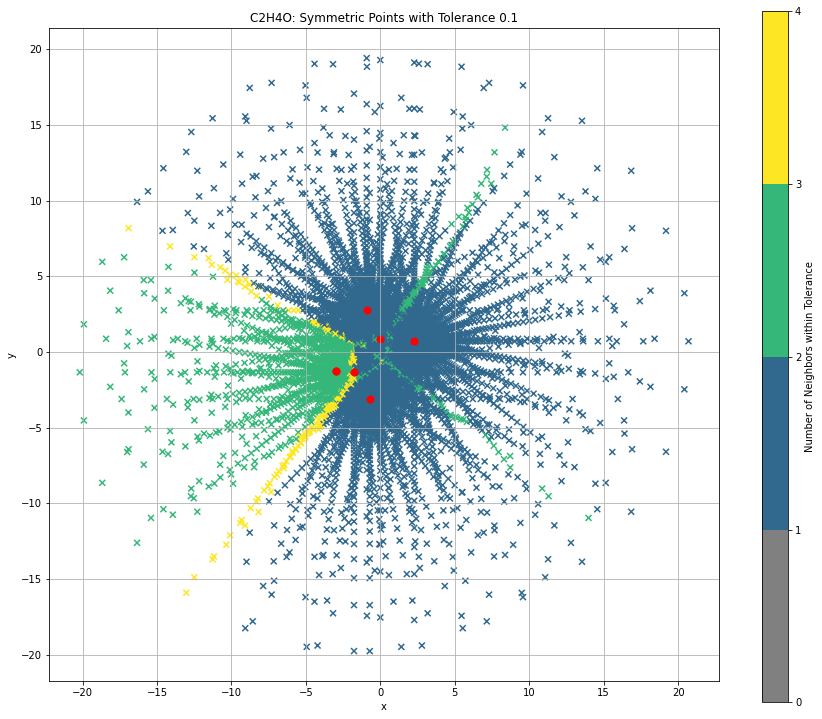

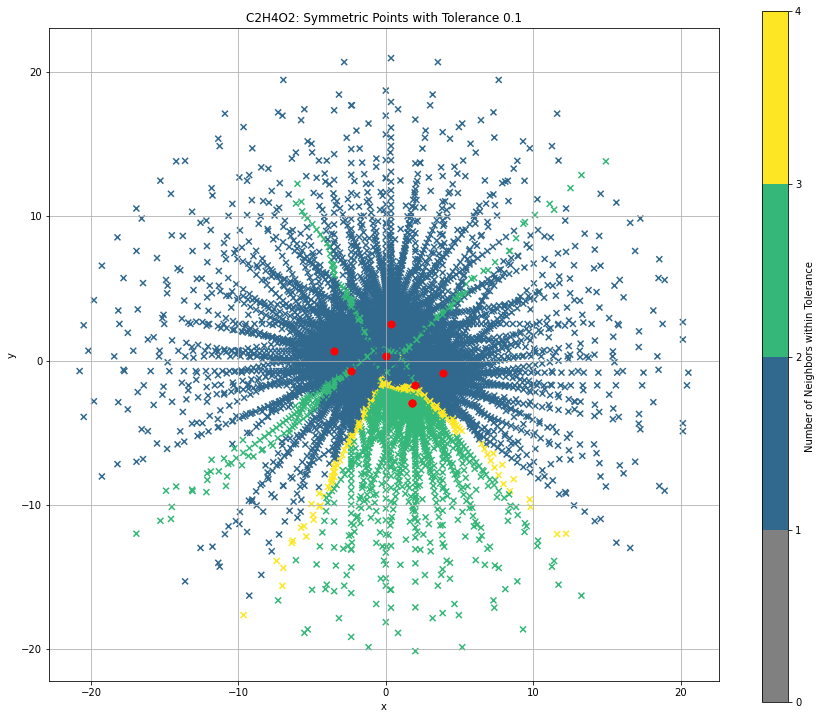

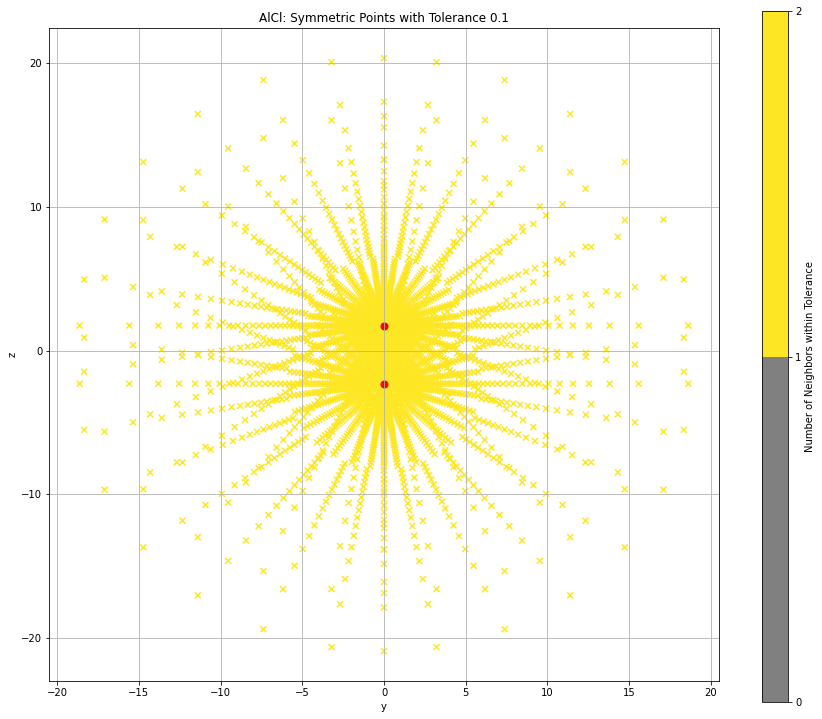

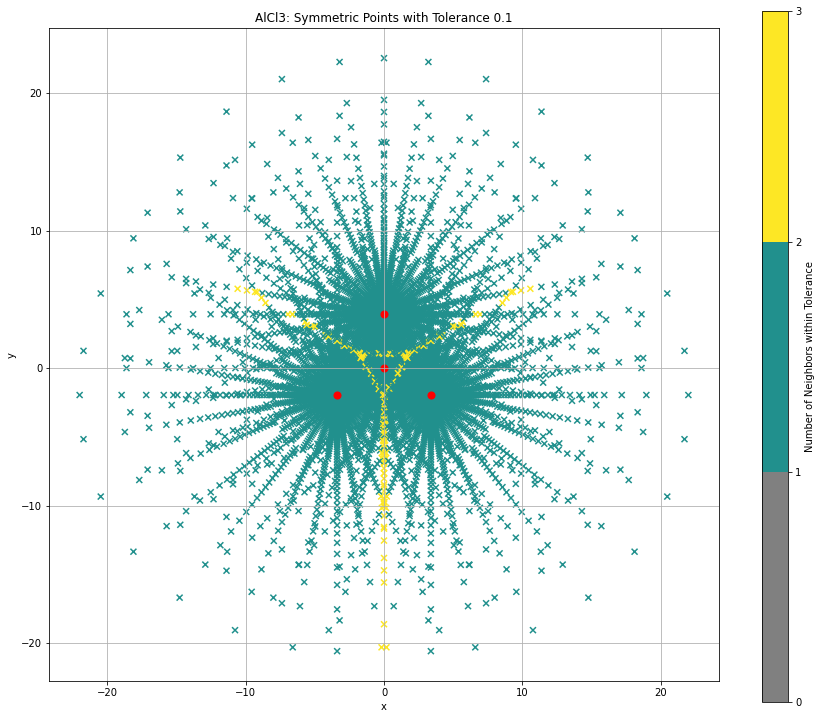

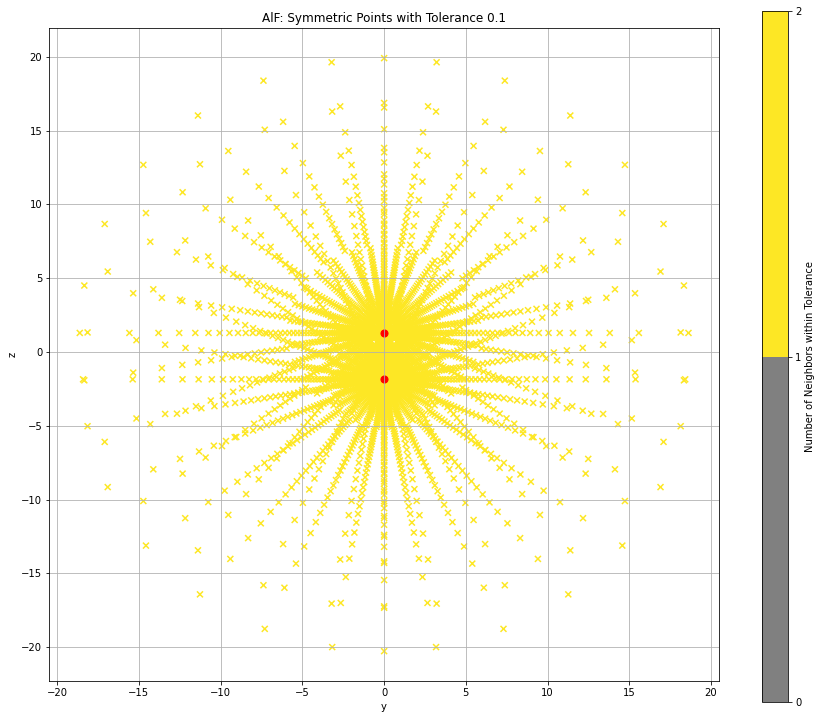

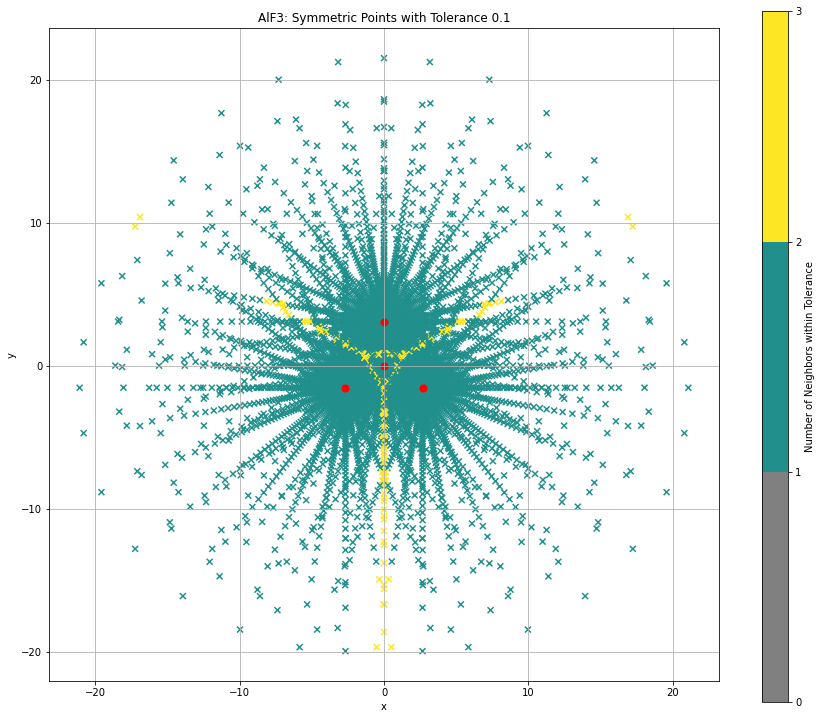

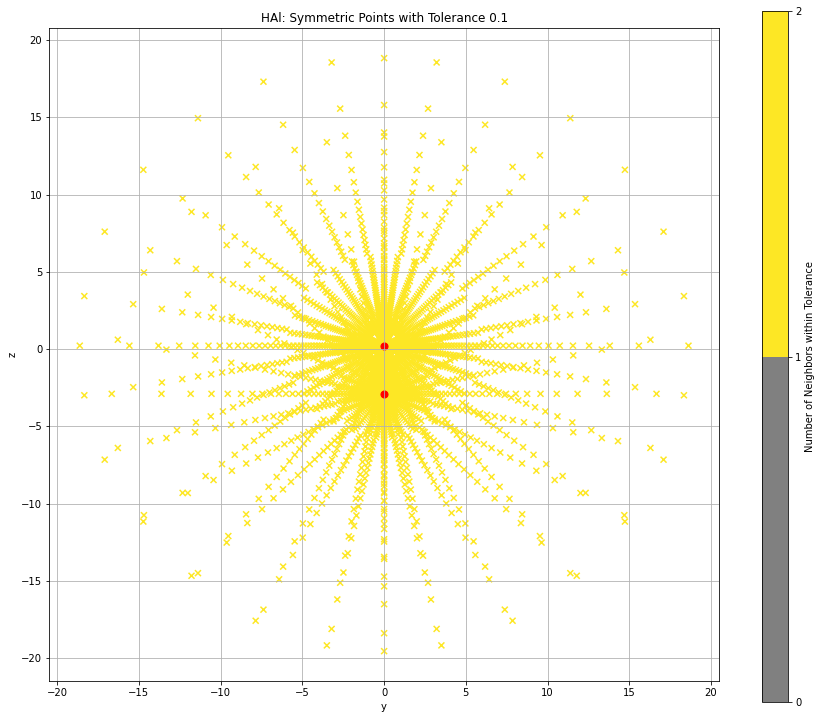

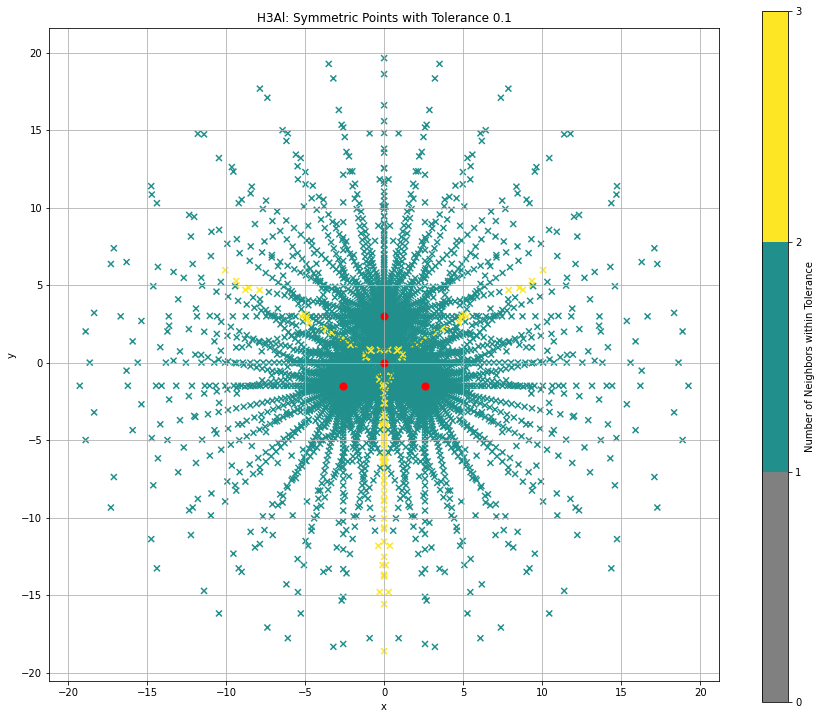

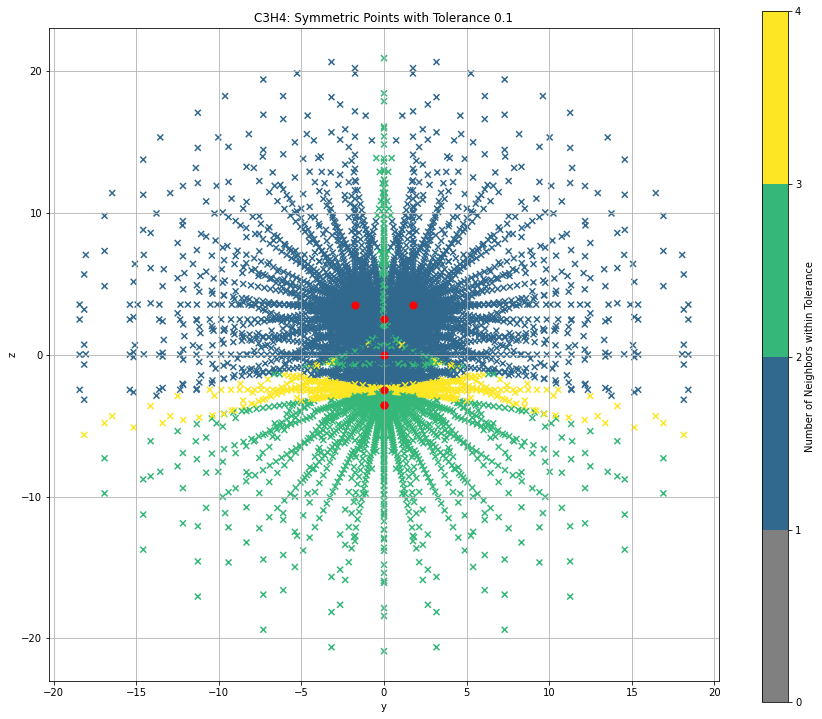

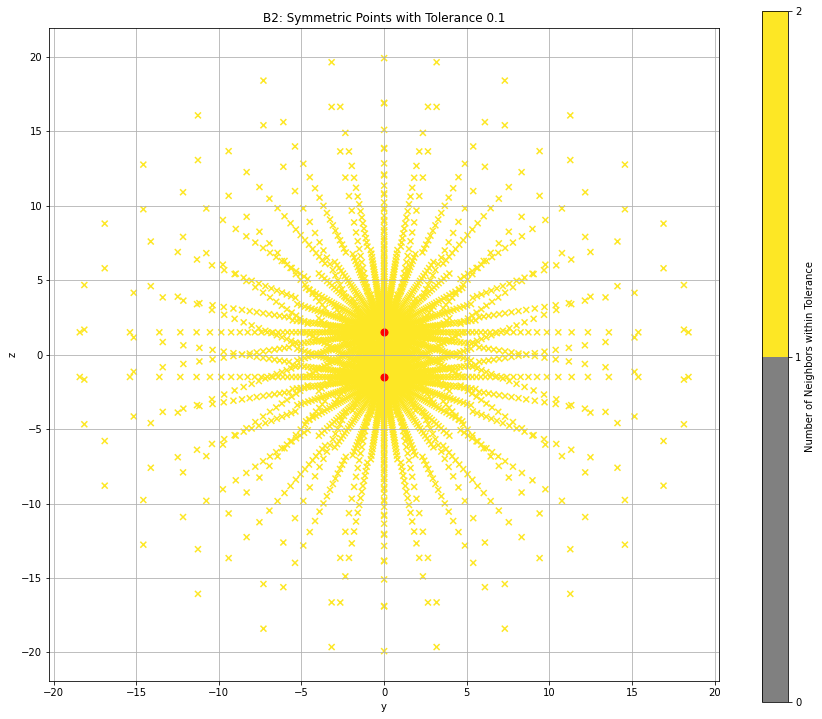

In [252]:
for at in traj[:10]:
    name, mol = ase_atoms_to_mol(at)
    mf, method = gen_mf_mol(mol, pol=True, xc='PBE', grid_level=5)
    plot_symm_slice(mf, formula=at.get_chemical_formula(), neighbortol=1e-1)

In [217]:
aind = 8
at = traj[aind]
name, mol = ase_atoms_to_mol(at)
mf, method = gen_mf_mol(mol, pol=True, xc='PBE', grid_level=5)
mol.atom

Building grids...
METHOD GENERATED: <function UKS at 0x7fd5bf8bd3b0>


[['C', array([0., 0., 0.])],
 ['C', array([0.      , 0.      , 1.310515])],
 ['C', array([ 0.      ,  0.      , -1.310515])],
 ['H', array([-0.92902,  0.     , -1.86606])],
 ['H', array([ 0.92902,  0.     , -1.86606])],
 ['H', array([0.     , 0.92902, 1.86606])],
 ['H', array([ 0.     , -0.92902,  1.86606])]]

2


Text(0, 0.5, 'Number of Neighbors within Tolerance')

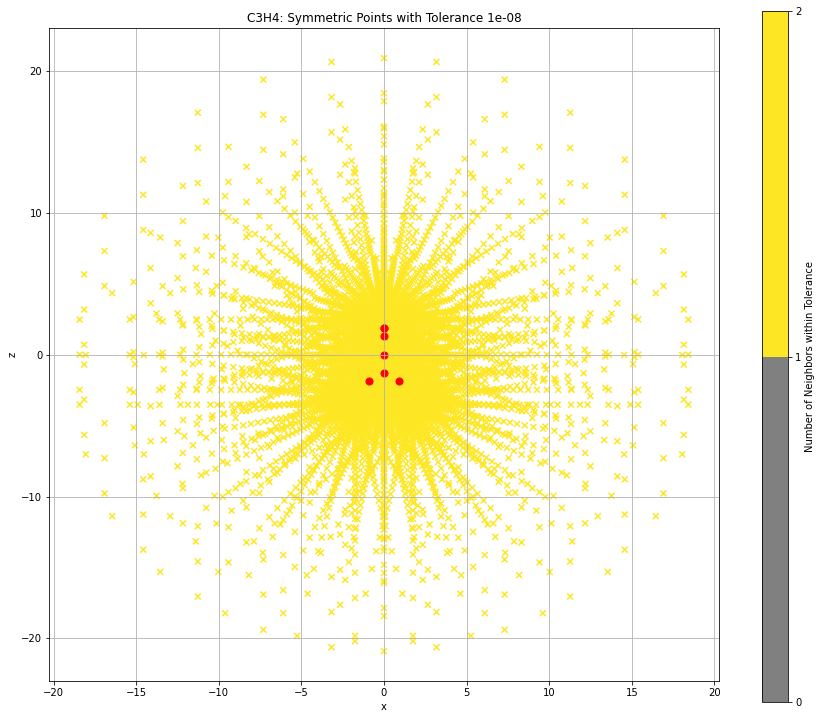

In [228]:
ntol = 1e-8
ds, nn, nnd, neighbs, nnn = grid_atom_distance(mf, neighbortol = ntol)
print(max(nnn))
d = mf.mol.atom_coords()[0]
c = mf.grids.coords
csli, csl = slice_grids(c, coli = 1, colval = 0)

xdimi = 0
ydimi = 2
xdimlab = get_axlbl(xdimi)
ydimlab = get_axlbl(ydimi)

atx = at.positions[:, xdimi]
aty = at.positions[:, ydimi]

xs = csl[:, xdimi]
ys = csl[:, ydimi]

xfs = np.linspace(xs.min(), xs.max())
yfs = ntol*np.ones_like(xfs)

#colormap setup
#define cmap
cmap = plt.cm.viridis
#extract all colors from map
cmaplist = [cmap(i) for i in range(cmap.N)]
#force first entry to be gray
cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
#new color map
cmap = colors.LinearSegmentedColormap.from_list('custcmap', cmaplist, cmap.N)
#bins and normalize
bounds = np.arange(0, max(np.array(nnn)[csli])+1)
norm = colors.BoundaryNorm(bounds, cmap.N)
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(111)
ax.grid()
ax.set_xlabel(xdimlab)
ax.set_ylabel(ydimlab)
ax.scatter(xs, ys, marker='x', c=np.array(nnn)[csli], alpha=1, cmap=cmap, norm=norm)
ax.scatter(atx, aty, marker='o', c='r', s=50)
ax.set_title('{}: Symmetric Points with Tolerance {}'.format(at.get_chemical_formula(), ntol))

#create colorbar
ax2 = f.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
ax2.set_ylabel('Number of Neighbors within Tolerance')

In [175]:
csl[:, 0]

array([ 3.06474394e-06,  2.81631126e-05,  1.03075825e-04, ...,
       -5.17894016e+00, -5.42811798e+00, -5.69402873e+00])

In [211]:
tst = read('/home/awills/Documents/Research/swxcd/aegis/xcdw_ps/rxnw.traj', ':')
for idx, at in enumerate(tst):
    print(idx, at, at.info)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
5 Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}
6 Atoms(symbols='F2', pbc=False, calculator=SinglePointCalculator(...)) {'F2': True, 'name': '

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)
